In [62]:
# Important constants
directory = '../tcp_server/out'
filename = '../tcp_server/out/walk.00002.csv'
em_learn_output_path = '../src/step_counter_model.h'
sample_rate = 100 # Hz
window_size_seconds = 1
window_size = sample_rate * window_size_seconds
step_size = window_size // 2
n_features = 6 # Number of statistical features to extract from the data

# Different sizes of random forest regressor, for hyperparameter tuning
param_grid = {
    'n_estimators': [3, 5, 7],
    'max_depth': [3, 5, 7],
    'max_features': [2, 4, 6],
}

# Actions taken while collecting data
actions = [
    "chairracing",
    "jog",
    "pushups",
    "squats",
    "walk"
]

In [63]:
# Read the data
import pandas as pd
import os

dataFrames = []

n_datapoints = 0
n_steps = 0

for file in os.listdir(directory):
    # Read files
    dataFrames.append(pd.read_csv(os.path.join(directory, file), header=0))
    
    # Add type to files, so we can identify them later
    dataFrames[-1]['type'] = file.split('.')[0]

    n_datapoints += len(dataFrames[-1])
    n_steps += dataFrames[-1]['step'].sum()
    
    #print(f"Read {file}")

print(f"Total number of datapoints: {n_datapoints}")
print(f"Total number of steps: {n_steps}")

Total number of datapoints: 158723
Total number of steps: 2636


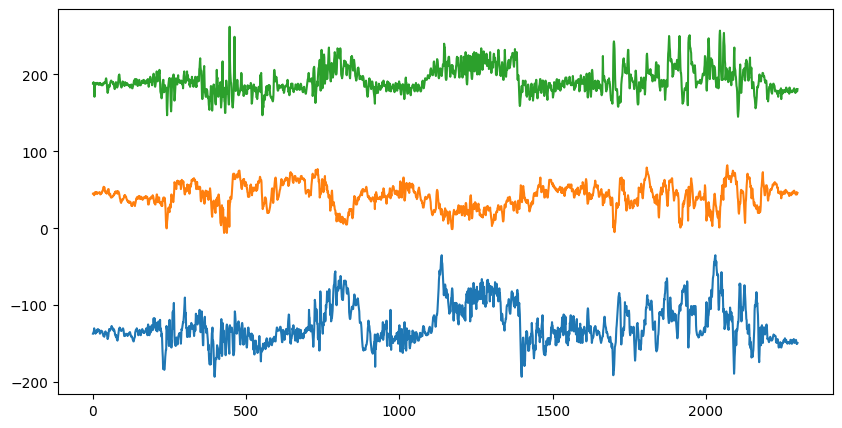

In [64]:
# Plot a single file to see the data
import matplotlib.pyplot as plt

for i in range(1):
    
    # File to plot
    plot_data = dataFrames[i]

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(plot_data['accX'], label='acc_x')
    plt.plot(plot_data['accY'], label='acc_y')
    plt.plot(plot_data['accZ'], label='acc_z')


In [65]:
############################################################################
# Calculate features
############################################################################
import numpy as np
from scipy.signal import find_peaks

# Dataframe to contain statistical features from each window
inputData = pd.DataFrame()
# Array to contain the output of each window (whether it contains a 1)
outputData = []
# Array to contain types of action for each window
dataTypes = []

dataIndex = 0

# Repeat for each file in the directory
for data in dataFrames:
    
    print(f"Processing {data['type'][0]}")

    X = data.drop("step", axis='columns').drop("type", axis='columns')
    y = data["step"]

    # We only want whole windows, remove the last few samples if they don't fit
    inputDataRaw = X[:len(X) - (len(X) % step_size)]
    outputDataRaw = y[:len(y) - (len(y) % step_size)]
    numberOfWindows = int((len(inputDataRaw)-window_size) / step_size) + 1

    # All accelerations are int16_t, and there will be 500 samples in 5 seconds, therefore, some values are int16_t, some are int32_t, and some (energy) are int64_t

    # Calculate features for each window (Heavy features are commented out, as these may be too slow on embedded systems)
    # The features are calculated for each window, and the output is the number of steps in that window
    for windowNumber in range(0, numberOfWindows):
        dataIndex += 1
        # Get the start and end of the window
        start = windowNumber * step_size
        end = start + window_size

        # Output data
        outputData.append(outputDataRaw[start:end].sum())

        # x, y and z data
        x_list = X['accX'][start:end]
        y_list = X['accY'][start:end]
        z_list = X['accZ'][start:end]

        # Get type of action
        dataTypes.append(data['type'][0])

        # Calculate features for the window

        # Mean - int16_t
        inputData.loc[dataIndex, 'mean_x'] = x_list.mean()
        inputData.loc[dataIndex, 'mean_y'] = y_list.mean()
        inputData.loc[dataIndex, 'mean_z'] = z_list.mean()

        # Std. dev - int16_t
        inputData.loc[dataIndex, 'std_x'] = x_list.std()
        inputData.loc[dataIndex, 'std_y'] = y_list.std()
        inputData.loc[dataIndex, 'std_z'] = z_list.std()

        # Avg. absolute diff - int16_t
        inputData.loc[dataIndex, 'mean_abs_diff_x'] = np.mean(np.abs(x_list - x_list.mean()))
        inputData.loc[dataIndex, 'mean_abs_diff_y'] = np.mean(np.abs(y_list - y_list.mean()))
        inputData.loc[dataIndex, 'mean_abs_diff_z'] = np.mean(np.abs(z_list - z_list.mean()))

        # Min - int16_t
        inputData.loc[dataIndex, 'min_x'] = x_list.min()
        inputData.loc[dataIndex, 'min_y'] = y_list.min()
        inputData.loc[dataIndex, 'min_z'] = z_list.min()

        # Max - int16_t
        inputData.loc[dataIndex, 'max_x'] = x_list.max()
        inputData.loc[dataIndex, 'max_y'] = y_list.max()
        inputData.loc[dataIndex, 'max_z'] = z_list.max()
        
        # Max-min diff - int16_t
        inputData.loc[dataIndex, 'max_min_diff_x'] = x_list.max() - x_list.min()
        inputData.loc[dataIndex, 'max_min_diff_y'] = y_list.max() - y_list.min()
        inputData.loc[dataIndex, 'max_min_diff_z'] = z_list.max() - z_list.min()

        # Median - int16_t
        # inputData.loc[dataIndex, 'median_x'] = x_list.median()
        # inputData.loc[dataIndex, 'median_y'] = y_list.median()
        # inputData.loc[dataIndex, 'median_z'] = z_list.median()

        # Median abs. deviation - int16_t
        # inputData.loc[dataIndex, 'median_abs_dev_x'] = np.median(np.abs(x_list - x_list.median()))
        # inputData.loc[dataIndex, 'median_abs_dev_y'] = np.median(np.abs(y_list - y_list.median())) 
        # inputData.loc[dataIndex, 'median_abs_dev_z'] = np.median(np.abs(z_list - z_list.median()))

        # Interquartile range - int16_t
        # inputData.loc[dataIndex, 'iqr_x'] = x_list.quantile(0.75) - x_list.quantile(0.25)
        # inputData.loc[dataIndex, 'iqr_y'] = y_list.quantile(0.75) - y_list.quantile(0.25)
        # inputData.loc[dataIndex, 'iqr_z'] = z_list.quantile(0.75) - z_list.quantile(0.25)

        # Negative count - int16_t
        inputData.loc[dataIndex, 'neg_count_x'] = x_list[x_list < 0].count()
        inputData.loc[dataIndex, 'neg_count_y'] = y_list[y_list < 0].count()
        inputData.loc[dataIndex, 'neg_count_z'] = z_list[z_list < 0].count()

        # Positive count - int16_t
        inputData.loc[dataIndex, 'pos_count_x'] = x_list[x_list > 0].count()
        inputData.loc[dataIndex, 'pos_count_y'] = y_list[y_list > 0].count()
        inputData.loc[dataIndex, 'pos_count_z'] = z_list[z_list > 0].count()

        # Values above mean - int16_t
        inputData.loc[dataIndex, 'above_mean_count_x'] = x_list[x_list > x_list.mean()].count()
        inputData.loc[dataIndex, 'above_mean_count_y'] = y_list[y_list > y_list.mean()].count()
        inputData.loc[dataIndex, 'above_mean_count_z'] = z_list[z_list > z_list.mean()].count()

        # Number of peaks - int16_t
        # inputData.loc[dataIndex, 'peaks_x'] = len(find_peaks(x_list)[0])
        # inputData.loc[dataIndex, 'peaks_y'] = len(find_peaks(y_list)[0])
        # inputData.loc[dataIndex, 'peaks_z'] = len(find_peaks(z_list)[0])

        # Skewness - int16_t
        # inputData.loc[dataIndex, 'skew_x'] = x_list.skew()
        # inputData.loc[dataIndex, 'skew_y'] = y_list.skew()
        # inputData.loc[dataIndex, 'skew_z'] = z_list.skew()

        # Kurtosis - int16_t
        # inputData.loc[dataIndex, 'kurtosis_x'] = x_list.kurtosis()
        # inputData.loc[dataIndex, 'kurtosis_y'] = y_list.kurtosis()
        # inputData.loc[dataIndex, 'kurtosis_z'] = z_list.kurtosis()

        # Energy - int64_t
        inputData.loc[dataIndex, 'energy_x'] = np.sum(x_list**2)
        inputData.loc[dataIndex, 'energy_y'] = np.sum(y_list**2)
        inputData.loc[dataIndex, 'energy_z'] = np.sum(z_list**2)

        # Average resultant acceleration - int16_t
        inputData.loc[dataIndex, 'avg_resultant'] = np.mean(np.sqrt(x_list**2 + y_list**2 + z_list**2))

        # Signal magnitude area - int32_t
        inputData.loc[dataIndex, 'sma'] = np.sum(np.sqrt(x_list**2 + y_list**2 + z_list**2))

        # Time index of max value - int32_t
        # inputData.loc[dataIndex, 'time_index_max_x'] = x_list.idxmax()
        # inputData.loc[dataIndex, 'time_index_max_y'] = y_list.idxmax()
        # inputData.loc[dataIndex, 'time_index_max_z'] = z_list.idxmax()

        # Time index of min value - int32_t
        # inputData.loc[dataIndex, 'time_index_min_x'] = x_list.idxmin()
        # inputData.loc[dataIndex, 'time_index_min_y'] = y_list.idxmin()
        # inputData.loc[dataIndex, 'time_index_min_z'] = z_list.idxmin()

        # Difference of time index between max and min - int16_t
        # inputData.loc[dataIndex, 'time_index_diff_x'] = x_list.idxmax() - x_list.idxmin()
        # inputData.loc[dataIndex, 'time_index_diff_y'] = y_list.idxmax() - y_list.idxmin()
        # inputData.loc[dataIndex, 'time_index_diff_z'] = z_list.idxmax() - z_list.idxmin()


Processing chairracing
Processing chairracing
Processing chairracing
Processing jog
Processing jog
Processing jog
Processing jog
Processing jog
Processing jog
Processing jog
Processing pushups
Processing pushups
Processing pushups
Processing squats
Processing squats
Processing walk
Processing walk
Processing walk
Processing walk
Processing walk
Processing walk
Processing walk
Processing walk
Processing walk
Processing walk
Processing walk
Processing walk
Processing walk
Processing walk
Processing walk
Processing walk
Processing walk
Processing walk
Processing walk


In [66]:
############################################################################
# Split dataset
############################################################################
from sklearn.model_selection import train_test_split

inputDataTrain, inputDataTest, outputDataTrain, outputDataTest = train_test_split(
                                                                    inputData,
                                                                    outputData,
                                                                    test_size=0.2,
                                                                    stratify=dataTypes
                                                                )

In [67]:
# Select best features
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold

# Remove features with low variance
vt = VarianceThreshold(threshold=0.0)

inputDataTrain_noNames = vt.fit_transform(inputDataTrain)
inputDataTest_noNames = vt.transform(inputDataTest)

selected_features = inputDataTrain.columns[vt.get_support()]

inputDataTrain = pd.DataFrame(inputDataTrain_noNames, columns=selected_features)
inputDataTest = pd.DataFrame(inputDataTest_noNames, columns=selected_features)


# Select the best features using ANOVA F-value
selector = SelectKBest(score_func=f_classif, k=n_features)
inputDataTrain = selector.fit_transform(inputDataTrain, outputDataTrain)
inputDataTest = selector.transform(inputDataTest)

# Print the selected features
print("Selected features:")
print(selector.get_feature_names_out())

Selected features:
['std_z' 'mean_abs_diff_z' 'min_y' 'max_min_diff_x' 'max_min_diff_y'
 'max_min_diff_z']


In [68]:
# Find the best features and train model
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

estimator = GridSearchCV(RandomForestRegressor(random_state=1), param_grid, cv=5, scoring='r2')

estimator.fit(inputDataTrain, outputDataTrain)

print("Best parameters found:")
print(estimator.best_params_)

Best parameters found:
{'max_depth': 7, 'max_features': 2, 'n_estimators': 7}


In [69]:
# Test the model
from sklearn.metrics import get_scorer
score = get_scorer('r2')(estimator.best_estimator_, inputDataTest, outputDataTest) 

print("Score: ", int(score*100), "%", sep="")

Score: 70%


In [70]:
# Test model on dataset
dataset = [0, -196, 9, 6, 4, 4]
output = estimator.best_estimator_.predict([dataset])
print("Predicted output: ", int(output[0]), sep="")

Predicted output: 0


In [ ]:
# Convert model using emlearn
import emlearn
cmodel = emlearn.convert(estimator.best_estimator_, method='inline')
# Commented out, to avoid overwriting the model
#cmodel.save(file=em_learn_output_path, name='step_counter_model') 
print("Model saved to ", em_learn_output_path, sep="")

Model saved to ../src/step_counter_model.h
